In [ ]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#restart after

In [ ]:
# !pip uninstall -y torch
# !pip install torch==2.1.0+cpu torchvision==0.16.0+cpu torchaudio==2.1.0 -f https://download.pytorch.org/whl/torch_stable.html


In [1]:
!pip install scipy==1.10.1
#srestart after

In [2]:
!pip install geoopt torch

In [3]:

!git clone https://github.com/eamid/trimap.git

!pip install /kaggle/working/trimap


Cloning into 'trimap'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 397 (delta 36), reused 27 (delta 11), pack-reused 326 (from 1)
Receiving objects: 100% (397/397), 24.34 MiB | 38.83 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Processing ./trimap
  Preparing metadata (setup.py) ... done
  Created wheel for trimap: filename=trimap-1.1.4-py3-none-any.whl size=15441 sha256=883ca265e533bda59cd946b1e4d10e9e212d1acf5c264006c7b1a11a4e5aa4a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-te301ydh/wheels/45/3a/6c/c020cce2cbdba5170c6844451da08219301c3edadc9e02848b
Successfully built trimap


In [4]:
!pip install -q sentence-transformers geoopt umap-learn tqdm


In [5]:
import numpy as np
import torch
import torch.nn as nn
import geoopt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import os
import random
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from trimap import TRIMAP



# Setup
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs("embeddings", exist_ok=True)
os.makedirs("losses", exist_ok=True)

# Load Fashion MNIST (1000 samples)
(X, y), (_, _) = fashion_mnist.load_data()
X = X[:1000].reshape(-1, 28 * 28).astype(np.float32) / 255.0
y = y[:1000]
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Label names from Fashion MNIST
fashion_labels = [
    "T-shirt", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"
]

# Get sentence embeddings of labels
model = SentenceTransformer("all-MiniLM-L6-v2")
label_embeddings = model.encode(fashion_labels)
similarity_matrix = cosine_similarity(label_embeddings)

# Build semantic triplets based on cosine similarity
triplets = []
threshold = 0.65  # similarity threshold for "positive" pairs
for i in range(len(y)):
    for j in range(len(y)):
        if i != j:
            sim = similarity_matrix[y[i], y[j]]
            if sim >= threshold:
                # pick a semantically dissimilar third item
                k_candidates = [k for k in range(len(y)) if k != i and k != j and similarity_matrix[y[i], y[k]] < 0.4]
                if k_candidates:
                    k = random.choice(k_candidates)
                    triplets.append((i, j, k))

# Convert to tensor
triplets = torch.tensor(triplets).to(device)
print(f"Generated {len(triplets)} semantic triplets.")

# Save to .npy file
np.save("semantic_triplets_fashion.npy", triplets.cpu().numpy())
print("Triplets saved to semantic_triplets_fashion.npy")

# Dimensionality Reduction
def reduce_dim(X, method="pca"):
    if method == "pca":
        return PCA(n_components=2).fit_transform(X)
    elif method == "tsne":
        return TSNE(n_components=2, random_state=SEED).fit_transform(X)
    elif method == "umap":
        return umap.UMAP(n_components=2, random_state=SEED).fit_transform(X)
    elif method == "trimap":
        from trimap import TRIMAP
        return TRIMAP(n_dims=2).fit_transform(X)
    else:
        raise ValueError(f"Unknown method: {method}")

# Train Poincaré Embedding
def train_poincare_embedding(X_reduced, method):
    manifold = geoopt.PoincareBall(c=1.0)
    embed = geoopt.ManifoldParameter(
        manifold.random_normal((len(X_reduced), 2), std=0.1).to(device),
        manifold=manifold
    )

    optimizer = geoopt.optim.RiemannianAdam([embed], lr=1e-2)
    loss_fn = nn.TripletMarginLoss(margin=0.2, p=2)
    losses = []

    for epoch in tqdm(range(1000), desc=f"{method.upper()} training"):
        optimizer.zero_grad()
        anchor = embed[triplets[:, 0]]
        pos = embed[triplets[:, 1]]
        neg = embed[triplets[:, 2]]
        loss = loss_fn(anchor, pos, neg)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"[{method.upper()}] Epoch {epoch} - Loss: {loss.item():.4f}")

    emb_np = embed.detach().cpu().numpy()
    np.save(f"embeddings/poincare_embedding_{method}.npy", emb_np)
    np.save(f"losses/training_loss_{method}.npy", np.array(losses))
    print(f" Saved embedding and loss for {method}")

# Run pipeline
for method in ["pca", "umap", 'tsne', 'trimap']:
    print(f"\n--- Reducing with {method.upper()} ---")
    X_2d = reduce_dim(X, method)
    np.save(f"embeddings/original_embedding_{method}.npy", X_2d)
    train_poincare_embedding(X_2d, method)

print("\n All methods processed and saved.")
#1:39

2025-06-17 17:32:21.904341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750181542.456420     128 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750181542.587830     128 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated 120980 semantic triplets.
Triplets saved to semantic_triplets_fashion.npy

--- Reducing with PCA ---


PCA training:   0%|          | 1/1000 [00:00<02:55,  5.68it/s]

[PCA] Epoch 0 - Loss: 0.2000


PCA training:  16%|█▋        | 165/1000 [00:01<00:03, 218.99it/s]

[PCA] Epoch 100 - Loss: 0.0376


PCA training:  25%|██▌       | 252/1000 [00:01<00:02, 307.15it/s]

[PCA] Epoch 200 - Loss: 0.0004


PCA training:  38%|███▊      | 383/1000 [00:01<00:01, 385.96it/s]

[PCA] Epoch 300 - Loss: 0.0000


PCA training:  47%|████▋     | 470/1000 [00:02<00:01, 407.95it/s]

[PCA] Epoch 400 - Loss: 0.0000


PCA training:  56%|█████▌    | 559/1000 [00:02<00:01, 422.58it/s]

[PCA] Epoch 500 - Loss: 0.0000


PCA training:  65%|██████▍   | 647/1000 [00:02<00:00, 427.11it/s]

[PCA] Epoch 600 - Loss: 0.0000


PCA training:  78%|███████▊  | 777/1000 [00:02<00:00, 424.78it/s]

[PCA] Epoch 700 - Loss: 0.0000


PCA training:  86%|████████▌ | 862/1000 [00:03<00:00, 417.82it/s]

[PCA] Epoch 800 - Loss: 0.0000


PCA training:  95%|█████████▍| 948/1000 [00:03<00:00, 417.41it/s]

[PCA] Epoch 900 - Loss: 0.0000


PCA training: 100%|██████████| 1000/1000 [00:03<00:00, 297.20it/s]
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 Saved embedding and loss for pca

--- Reducing with UMAP ---


UMAP training:   8%|▊         | 78/1000 [00:00<00:02, 383.90it/s]

[UMAP] Epoch 0 - Loss: 0.2004


UMAP training:  16%|█▌        | 160/1000 [00:00<00:02, 401.61it/s]

[UMAP] Epoch 100 - Loss: 0.0392


UMAP training:  25%|██▍       | 247/1000 [00:00<00:01, 418.41it/s]

[UMAP] Epoch 200 - Loss: 0.0051


UMAP training:  38%|███▊      | 377/1000 [00:00<00:01, 422.62it/s]

[UMAP] Epoch 300 - Loss: 0.0000


UMAP training:  46%|████▋     | 463/1000 [00:01<00:01, 421.50it/s]

[UMAP] Epoch 400 - Loss: 0.0000


UMAP training:  55%|█████▍    | 549/1000 [00:01<00:01, 420.91it/s]

[UMAP] Epoch 500 - Loss: 0.0000


UMAP training:  68%|██████▊   | 678/1000 [00:01<00:00, 422.85it/s]

[UMAP] Epoch 600 - Loss: 0.0000


UMAP training:  77%|███████▋  | 766/1000 [00:01<00:00, 426.30it/s]

[UMAP] Epoch 700 - Loss: 0.0000


UMAP training:  85%|████████▌ | 853/1000 [00:02<00:00, 428.42it/s]

[UMAP] Epoch 800 - Loss: 0.0000


UMAP training:  98%|█████████▊| 982/1000 [00:02<00:00, 421.50it/s]

[UMAP] Epoch 900 - Loss: 0.0000


UMAP training: 100%|██████████| 1000/1000 [00:02<00:00, 419.33it/s]


 Saved embedding and loss for umap

--- Reducing with TSNE ---


TSNE training:   8%|▊         | 79/1000 [00:00<00:02, 392.57it/s]

[TSNE] Epoch 0 - Loss: 0.1999


TSNE training:  16%|█▋        | 165/1000 [00:00<00:02, 417.23it/s]

[TSNE] Epoch 100 - Loss: 0.0286


TSNE training:  25%|██▌       | 251/1000 [00:00<00:01, 413.81it/s]

[TSNE] Epoch 200 - Loss: 0.0011


TSNE training:  34%|███▎      | 335/1000 [00:00<00:01, 407.88it/s]

[TSNE] Epoch 300 - Loss: 0.0000


TSNE training:  47%|████▋     | 466/1000 [00:01<00:01, 414.94it/s]

[TSNE] Epoch 400 - Loss: 0.0000


TSNE training:  55%|█████▌    | 552/1000 [00:01<00:01, 417.74it/s]

[TSNE] Epoch 500 - Loss: 0.0000


TSNE training:  68%|██████▊   | 681/1000 [00:01<00:00, 420.09it/s]

[TSNE] Epoch 600 - Loss: 0.0000


TSNE training:  77%|███████▋  | 768/1000 [00:01<00:00, 392.84it/s]

[TSNE] Epoch 700 - Loss: 0.0000


TSNE training:  85%|████████▍ | 847/1000 [00:02<00:00, 377.75it/s]

[TSNE] Epoch 800 - Loss: 0.0000


TSNE training:  96%|█████████▌| 962/1000 [00:02<00:00, 367.62it/s]

[TSNE] Epoch 900 - Loss: 0.0000


TSNE training: 100%|██████████| 1000/1000 [00:02<00:00, 396.14it/s]


 Saved embedding and loss for tsne

--- Reducing with TRIMAP ---


TRIMAP training:   8%|▊         | 76/1000 [00:00<00:02, 376.23it/s]

[TRIMAP] Epoch 0 - Loss: 0.2003


TRIMAP training:  16%|█▌        | 159/1000 [00:00<00:02, 403.94it/s]

[TRIMAP] Epoch 100 - Loss: 0.0498


TRIMAP training:  25%|██▍       | 248/1000 [00:00<00:01, 424.55it/s]

[TRIMAP] Epoch 200 - Loss: 0.0110


TRIMAP training:  38%|███▊      | 383/1000 [00:00<00:01, 438.11it/s]

[TRIMAP] Epoch 300 - Loss: 0.0003


TRIMAP training:  47%|████▋     | 472/1000 [00:01<00:01, 435.72it/s]

[TRIMAP] Epoch 400 - Loss: 0.0000


TRIMAP training:  56%|█████▌    | 561/1000 [00:01<00:01, 429.73it/s]

[TRIMAP] Epoch 500 - Loss: 0.0000


TRIMAP training:  65%|██████▍   | 649/1000 [00:01<00:00, 430.32it/s]

[TRIMAP] Epoch 600 - Loss: 0.0000


TRIMAP training:  78%|███████▊  | 779/1000 [00:01<00:00, 421.23it/s]

[TRIMAP] Epoch 700 - Loss: 0.0000


TRIMAP training:  86%|████████▋ | 865/1000 [00:02<00:00, 419.80it/s]

[TRIMAP] Epoch 800 - Loss: 0.0000


TRIMAP training:  95%|█████████▌| 951/1000 [00:02<00:00, 420.94it/s]

[TRIMAP] Epoch 900 - Loss: 0.0000


TRIMAP training: 100%|██████████| 1000/1000 [00:02<00:00, 422.10it/s]

 Saved embedding and loss for trimap

 All methods processed and saved.


In [ ]:
import time
import tracemalloc
import os
import numpy as np
import torch
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import trustworthiness
from scipy.stats import spearmanr
from tensorflow.keras.datasets import fashion_mnist
import geoopt
import pandas as pd

# Load Fashion MNIST labels (2000 samples used in training)
(_, y), _ = fashion_mnist.load_data()
y = y[:1000]

methods = ["pca", "tsne", "umap", "trimap"]
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mean_intra_inter_ratio(embedding, labels):
    dists = pairwise_distances(embedding)
    intra, inter = [], []
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:
                intra.append(dists[i, j])
            else:
                inter.append(dists[i, j])
    intra = np.mean(intra)
    inter = np.mean(inter)
    return inter / intra if intra > 0 else 0

# Try loading precomputed semantic triplets
triplet_path = "/kaggle/working/semantic_triplets_fashion.npy"
triplets = None
if os.path.exists(triplet_path):
    triplets = torch.tensor(np.load(triplet_path), dtype=torch.long, device=device)

# Evaluate metrics
for method in methods:
    try:
        start_time = time.time()
        tracemalloc.start()

        emb_orig = np.load(f"/kaggle/working/embeddings/original_embedding_{method}.npy")
        emb = np.load(f"/kaggle/working/embeddings/poincare_embedding_{method}.npy")

        scores = {}
        for name, embedding in [("before", emb_orig), ("after", emb)]:
            silhouette = silhouette_score(embedding, y)
            db_index = davies_bouldin_score(embedding, y)
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(embedding, y)
            acc = np.mean(knn.predict(embedding) == y)
            global_score = mean_intra_inter_ratio(embedding, y)

            scores[f"silhouette_{name}"] = silhouette
            scores[f"db_index_{name}"] = db_index
            scores[f"knn_acc_{name}"] = acc
            scores[f"global_score_{name}"] = global_score

        high_dist = pairwise_distances(emb_orig)
        low_dist = pairwise_distances(emb)
        stress = np.sqrt(np.sum((high_dist - low_dist) ** 2) / np.sum(high_dist ** 2))
        flat_high = high_dist[np.triu_indices_from(high_dist, k=1)]
        flat_low = low_dist[np.triu_indices_from(low_dist, k=1)]
        spearman_corr = spearmanr(flat_high, flat_low).correlation
        trust = trustworthiness(emb_orig, emb, n_neighbors=5)

        scores["stress"] = stress
        scores["spearman_corr"] = spearman_corr
        scores["trustworthiness"] = trust

        if triplets is not None:
            emb_tensor = torch.tensor(emb, dtype=torch.float32, device=device)
            anchors = emb_tensor[triplets[:, 0]]
            positives = emb_tensor[triplets[:, 1]]
            negatives = emb_tensor[triplets[:, 2]]

            d_ap = torch.norm(anchors - positives, dim=1)
            d_an = torch.norm(anchors - negatives, dim=1)
            triplet_acc = (d_ap < d_an).float().mean().item()

            manifold = geoopt.PoincareBall(c=1.0)
            hyp_d_ap = manifold.dist(anchors, positives)
            hyp_d_an = manifold.dist(anchors, negatives)
            hyp_dist = torch.cat((hyp_d_ap, hyp_d_an)).mean().item()

            scores["triplet_acc"] = triplet_acc
            scores["hyperbolic_dist"] = hyp_dist

        # Record runtime and memory usage
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        scores["runtime_sec"] = end_time - start_time
        scores["peak_memory_mb"] = peak / 10**6
        tracemalloc.stop()

        results[method] = scores

    except Exception as e:
        results[method] = {"error": str(e)}

df = pd.DataFrame(results).T

print(df)

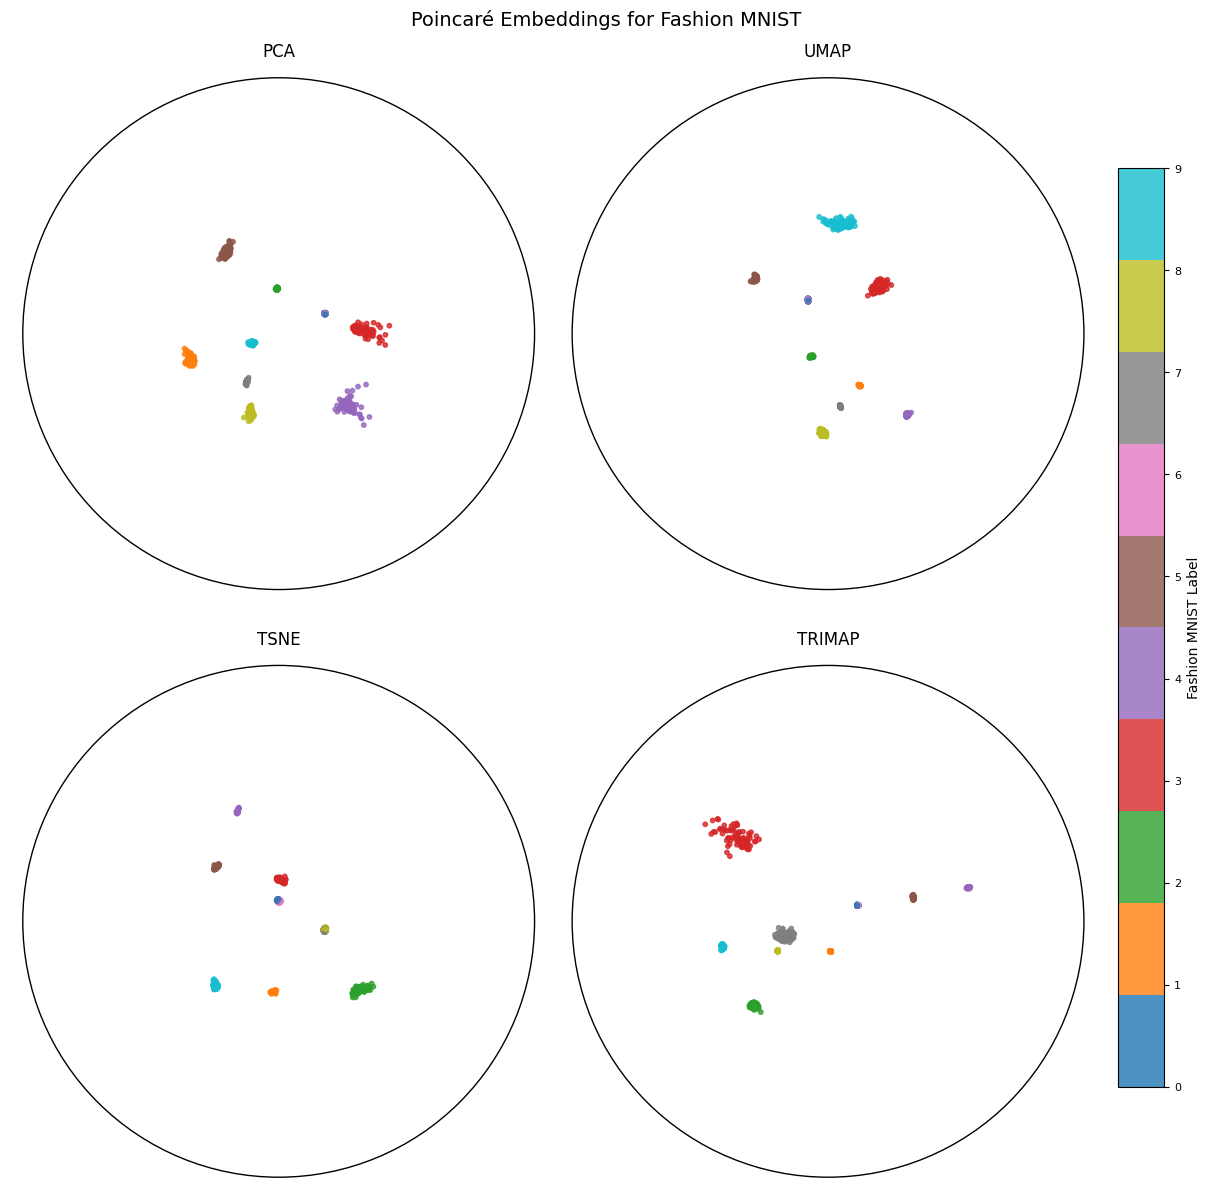

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load Fashion MNIST labels (first 10000, as in training)
(_, y), _ = fashion_mnist.load_data()
y = y[:1000]

methods = ["pca", "umap", 'tsne', 'trimap']
fig, axs = plt.subplots(2, 2, figsize=(12, 12), constrained_layout=True)
axs = axs.flatten()

for i, method in enumerate(methods):
    try:
        emb = np.load(f"embeddings/poincare_embedding_{method}.npy")
        assert len(emb) == len(y), f"Mismatch: embedding has {len(emb)}, labels have {len(y)}"

        ax = axs[i]
        ax.set_title(method.upper(), fontsize=12)
        ax.set_xlim(-1.05, 1.05)
        ax.set_ylim(-1.05, 1.05)
        ax.set_aspect('equal')
        ax.axis('off')

        # Draw Poincaré disk
        circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=1)
        ax.add_artist(circle)

        # Scatter plot with color labels
        scatter = ax.scatter(
            emb[:, 0], emb[:, 1],
            c=y, cmap='tab10', s=10, alpha=0.8
        )

    except Exception as e:
        print(f"Could not load {method}: {e}")
        axs[i].set_title(f"{method.upper()} (Error)")

# Add colorbar outside the plot (right side)
cbar = fig.colorbar(
    scatter, ax=axs, orientation='vertical',
    fraction=0.05, pad=0.02, shrink=0.8,
    location='right'
)
cbar.set_label('Fashion MNIST Label', fontsize=10)
cbar.ax.tick_params(labelsize=8)

plt.suptitle("Poincaré Embeddings for Fashion MNIST", fontsize=14)
plt.show()


In [ ]:
import time
import tracemalloc
import os
import numpy as np
import torch
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import trustworthiness
from scipy.stats import spearmanr
from tensorflow.keras.datasets import fashion_mnist
import geoopt
import pandas as pd

# Load Fashion MNIST labels (2000 samples used in training)
(_, y), _ = fashion_mnist.load_data()
y = y[:1000]

methods = ["pca", "tsne", "umap", "trimap"]
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mean_intra_inter_ratio(embedding, labels):
    dists = pairwise_distances(embedding)
    intra, inter = [], []
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:
                intra.append(dists[i, j])
            else:
                inter.append(dists[i, j])
    intra = np.mean(intra)
    inter = np.mean(inter)
    return inter / intra if intra > 0 else 0

# Try loading precomputed semantic triplets
triplet_path = "semantic_triplets_fashion.npy"
triplets = None
if os.path.exists(triplet_path):
    triplets = torch.tensor(np.load(triplet_path), dtype=torch.long, device=device)

# Evaluate metrics
for method in methods:
    try:
        start_time = time.time()
        tracemalloc.start()

        emb_orig = np.load(f"embeddings/original_embedding_{method}.npy")
        emb = np.load(f"embeddings/poincare_embedding_{method}.npy")

        scores = {}
        for name, embedding in [("before", emb_orig), ("after", emb)]:
            silhouette = silhouette_score(embedding, y)
            db_index = davies_bouldin_score(embedding, y)
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(embedding, y)
            acc = np.mean(knn.predict(embedding) == y)
            global_score = mean_intra_inter_ratio(embedding, y)

            scores[f"silhouette_{name}"] = silhouette
            scores[f"db_index_{name}"] = db_index
            scores[f"knn_acc_{name}"] = acc
            scores[f"global_score_{name}"] = global_score

        high_dist = pairwise_distances(emb_orig)
        low_dist = pairwise_distances(emb)
        stress = np.sqrt(np.sum((high_dist - low_dist) ** 2) / np.sum(high_dist ** 2))
        flat_high = high_dist[np.triu_indices_from(high_dist, k=1)]
        flat_low = low_dist[np.triu_indices_from(low_dist, k=1)]
        spearman_corr = spearmanr(flat_high, flat_low).correlation
        trust = trustworthiness(emb_orig, emb, n_neighbors=5)

        scores["stress"] = stress
        scores["spearman_corr"] = spearman_corr
        scores["trustworthiness"] = trust

        if triplets is not None:
            emb_tensor = torch.tensor(emb, dtype=torch.float32, device=device)
            anchors = emb_tensor[triplets[:, 0]]
            positives = emb_tensor[triplets[:, 1]]
            negatives = emb_tensor[triplets[:, 2]]

            d_ap = torch.norm(anchors - positives, dim=1)
            d_an = torch.norm(anchors - negatives, dim=1)
            triplet_acc = (d_ap < d_an).float().mean().item()

            manifold = geoopt.PoincareBall(c=1.0)
            hyp_d_ap = manifold.dist(anchors, positives)
            hyp_d_an = manifold.dist(anchors, negatives)
            hyp_dist = torch.cat((hyp_d_ap, hyp_d_an)).mean().item()

            scores["triplet_acc"] = triplet_acc
            scores["hyperbolic_dist"] = hyp_dist

        # Record runtime and memory usage
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        scores["runtime_sec"] = end_time - start_time
        scores["peak_memory_mb"] = peak / 10**6
        tracemalloc.stop()

        results[method] = scores

    except Exception as e:
        results[method] = {"error": str(e)}

df = pd.DataFrame(results).T

print(df)